# Step 6.2: AI Analysis & Advanced Reporting
Generates AI-powered insights, deep-dive analytics, Word reports, and PowerPoint presentations.
**Prerequisite:** Run Step 6.1 first to generate basic data.

**Features:**
- ✅ AI Individual Performance Reports
- ✅ Class-level AI Analytics
- ✅ Question-level Metrics & Visualizations
- ✅ AI Question Insights & Infographics
- ✅ Comprehensive Word Report
- ✅ PowerPoint Presentation

In [1]:
from grading_utils import setup_paths, create_directories, build_student_id_mapping
import os
import json
import pandas as pd
import shutil
import time
from datetime import datetime
from pathlib import Path
from PIL import Image
import cv2
from IPython.display import display, clear_output
from ipywidgets import IntProgress, HTML
import logging
from pypdf import PdfReader, PdfWriter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import math
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt, Inches


# Robust logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ Robust Step 6: Post-Scoring Packaging initialized")
print(f"✓ Session started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Configuration
passingMark = 15  # Adjust as needed
prefix = "VTC Test"
paths = setup_paths(prefix, "sample")

# Extract commonly used paths
pdf_file = paths["pdf_file"]
name_list_file = paths["name_list_file"]
base_path = paths["base_path"]
base_path_images = paths["base_path_images"]
base_path_annotations = paths["base_path_annotations"]
base_path_questions = paths["base_path_questions"]
base_path_marked_images = paths["base_path_marked_images"]
base_path_marked_pdfs = paths["base_path_marked_pdfs"]
base_path_marked_scripts = paths["base_path_marked_scripts"]
CACHE_DIR = paths.get("cache_dir", "../cache")

# Create all necessary directories
create_directories(paths)

print("✓ Paths configured and directories created")

# Metadata questions that should be excluded from answer analysis
METADATA_QUESTIONS = ["NAME", "ID", "CLASS"]

print("💡 Metadata questions (NAME, ID, CLASS) will be excluded from answer analysis")

✅ Robust Step 6: Post-Scoring Packaging initialized
✓ Session started at: 2026-01-09 07:57:10
✓ Paths configured and directories created
💡 Metadata questions (NAME, ID, CLASS) will be excluded from answer analysis


In [2]:
# Define paths for existing reports
base_path_marked_scripts = paths.get("base_path_marked_scripts", "marked/scripts/")
details_report_path = os.path.join(base_path_marked_scripts, "details_score_report.xlsx")
summary_report_path = os.path.join(base_path_marked_scripts, "score_report.xlsx")

print(f"✓ Using existing report path: {details_report_path}")


✓ Using existing report path: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx


In [3]:
# Robust score report generation with validation and analytics

def generate_score_report():
    """Generate comprehensive score report with validation and analytics."""
    logger.info("📊 Generating score report...")
    try:
        name_list_df = pd.read_excel(name_list_file, sheet_name="Name List")
        id_col = next((col for col in name_list_df.columns if col.lower() == "id"), None)
        name_col = next(
            (col for col in name_list_df.columns if col.lower() in {"name", "student name", "student_name"}),
            None,
        )
        if id_col is None or name_col is None:
            raise ValueError("Name list must contain ID and NAME columns.")

        name_map = (
            name_list_df.assign(**{id_col: name_list_df[id_col].astype(str)})
            .set_index(id_col)[name_col]
            .astype(str)
            .to_dict()
        )
        logger.info(f"✓ Loaded {len(name_map)} student names from name list")

        pageToStudentId, numberOfPage, getStudentId = build_student_id_mapping(
            base_path_questions, base_path_annotations
        )
        logger.info(f"✓ Built student ID mapping for {numberOfPage} pages")

        questionAndMarks = {}
        questions_processed = 0
        for path, _, files in os.walk(base_path_questions):
            for file in files:
                if file == "mark.json":
                    question = path[len(base_path_questions) + 1 :]
                    try:
                        with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                            data = json.load(f)
                        marks = {}
                        for item in data:
                            studentId = getStudentId(int(item["id"]))
                            marks[studentId] = (
                                item["overridedMark"] if item["overridedMark"] != "" else item["mark"]
                            )
                        questionAndMarks[question] = marks
                        questions_processed += 1
                        logger.info(f"✓ Processed marks for {question}: {len(marks)} students")
                    except Exception as e:
                        logger.error(f"❌ Failed to process marks for {question}: {e}")
                        continue

        logger.info(f"✓ Processed marks from {questions_processed} questions")
        if not questionAndMarks:
            raise ValueError("No question marks were processed.")
       
        marksDf = pd.DataFrame(questionAndMarks)

        # Reorder columns: ID, NAME, CLASS first, then questions sorted
        base_cols = ["ID", "NAME", "CLASS"]
        question_cols = [
            col
            for col in sorted(marksDf.columns)
            if col not in base_cols
        ]
        marksDf = marksDf[base_cols + question_cols]

        marksDf["NAME"] = marksDf["ID"].map(name_map).fillna(marksDf["NAME"])

        

        # Calculate total marks from question columns only
        marksDf["Marks"] = (
            marksDf.loc[:, ~marksDf.columns.isin(["ID", "NAME", "CLASS"])]
            .apply(pd.to_numeric, errors="coerce")
            .sum(axis=1)
        )

        invalid_marks = marksDf[marksDf["Marks"].isna()]
        if not invalid_marks.empty:
            logger.warning(f"Found {len(invalid_marks)} students with invalid marks")

        logger.info(f"✓ Generated marks report for {len(marksDf)} students")
        logger.info(f"  Average score: {marksDf['Marks'].mean():.2f}")
        logger.info(f"  Score range: {marksDf['Marks'].min():.1f} - {marksDf['Marks'].max():.1f}")

        return marksDf
    except Exception as e:
        logger.error(f"❌ Score report generation failed: {e}")
        raise


marksDf = generate_score_report()
display(marksDf)


2026-01-09 07:57:10,281 - INFO - 📊 Generating score report...
2026-01-09 07:57:10,501 - INFO - ✓ Loaded 4 student names from name list
2026-01-09 07:57:10,503 - INFO - ✓ Built student ID mapping for 2 pages
2026-01-09 07:57:10,505 - INFO - ✓ Processed marks for Q5: 4 students
2026-01-09 07:57:10,507 - INFO - ✓ Processed marks for Q4: 4 students
2026-01-09 07:57:10,508 - INFO - ✓ Processed marks for NAME: 4 students
2026-01-09 07:57:10,509 - INFO - ✓ Processed marks for CLASS: 4 students
2026-01-09 07:57:10,511 - INFO - ✓ Processed marks for Q3: 4 students
2026-01-09 07:57:10,512 - INFO - ✓ Processed marks for Q2: 4 students
2026-01-09 07:57:10,514 - INFO - ✓ Processed marks for Q1: 4 students
2026-01-09 07:57:10,516 - INFO - ✓ Processed marks for ID: 4 students
2026-01-09 07:57:10,517 - INFO - ✓ Processed marks from 8 questions
2026-01-09 07:57:10,538 - INFO - ✓ Generated marks report for 4 students
2026-01-09 07:57:10,541 - INFO -   Average score: 14.50
2026-01-09 07:57:10,545 - INFO 

,ID,NAME,CLASS,Q1,Q2,Q3,Q4,Q5,Marks
234567890,234567890,John,C,1.0,0.0,4.0,0.0,6.0,11.0
123456789,123456789,Peter,A,2.0,10.0,1.0,8.0,3.0,24.0
987654321,987654321,Mary,B,1.0,10.0,0.0,0.0,0.0,11.0
345678912,345678912,Susan,D,2.0,10.0,0.0,0.0,0.0,12.0


In [4]:
# Re-initialize student ID mapping for global use
print("🔄 Re-initializing student ID mapping...")
pageToStudentId, numberOfPage, getStudentId = build_student_id_mapping(
    base_path_questions, base_path_annotations
)
print(f"✓ Mapped {len(pageToStudentId)} pages to students")


🔄 Re-initializing student ID mapping...
✓ Mapped 4 pages to students


In [5]:
# Robust answer collection and reasoning with metadata exclusion
import pandas as pd
import re

def clean_answer_text(val: str) -> str:
    """Strip leading numbering and drop standalone question labels like Q2."""
    if not isinstance(val, str):
        return val
    lines = [ln.strip() for ln in str(val).splitlines()]
    cleaned = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+\s*[\.|\)]\s*", "", ln)
        if re.fullmatch(r"q\d+", ln, flags=re.IGNORECASE):
            continue
        if ln:
            cleaned.append(ln)
    return "\n".join(cleaned).strip()

def collect_answers_and_reasoning():
    """Gather per-student answers and model reasoning from each question's CSV and pivot to a mark-style wide format."""
    print("📝 Collecting answers and reasoning from question data...")
    
    answer_rows = []
    reasoning_rows = []
    questions_processed = 0

    for path, currentDirectory, files in os.walk(base_path_questions):
        if "data.csv" not in files:
            continue

        question = path[len(base_path_questions) + 1 :]
        
        # Skip metadata questions (NAME, ID, CLASS)
        if question in METADATA_QUESTIONS:
            logger.info(f"⏭️ Skipping metadata question: {question}")
            continue
            
        data_path = os.path.join(path, "data.csv")
        
        try:
            df = pd.read_csv(data_path)
            if "page" not in df.columns:
                logger.warning(f"No 'page' column in {question} data.csv")
                continue

            # Map scanned page back to student ID using the existing helper
            df["StudentID"] = df["page"].apply(
                lambda p: getStudentId(int(str(p).split(".")[0])) if pd.notna(p) else None
            )

            for _, row in df.iterrows():
                sid = row.get("StudentID")
                if sid is None:
                    continue

                raw_answer = row.get("Answer", "")
                answer_val = clean_answer_text(raw_answer)
                source_page = row.get("page", "")
                row_number = row.get("RowNumber", "")

                answer_rows.append(
                    {
                        "ID": str(sid),
                        "Question": question,
                        "Answer": answer_val,
                        "SourcePage": source_page,
                        "RowNumber": row_number,
                    }
                )

                reasoning_rows.append(
                    {
                        "ID": str(sid),
                        "Question": question,
                        "Reasoning": row.get("Reasoning", ""),
                        "Similarity": row.get("Similarity", ""),
                        "ModelMark": row.get("Mark", ""),
                        "Answer": answer_val,
                        "SourcePage": source_page,
                        "RowNumber": row_number,
                    }
                )
            
            questions_processed += 1
            logger.info(f"✓ Processed answers for {question}: {len(df)} entries")
            
        except Exception as e:
            logger.error(f"❌ Failed to process {question}: {e}")
            continue

    answers_df = pd.DataFrame(answer_rows)
    reasoning_df = pd.DataFrame(reasoning_rows)

    if not answers_df.empty:
        answers_df = answers_df.sort_values(
            by=["ID", "Question", "SourcePage", "RowNumber"]
        ).reset_index(drop=True)
    if not reasoning_df.empty:
        reasoning_df = reasoning_df.sort_values(
            by=["ID", "Question", "SourcePage", "RowNumber"]
        ).reset_index(drop=True)

    # Preserve ID/NAME/CLASS to match marks layout
    meta_cols = ["ID", "NAME", "CLASS"]
    student_meta = marksDf[meta_cols].drop_duplicates().set_index("ID")

    # Keep question ordering aligned with marks sheet (excluding metadata)
    question_cols = [
        col
        for col in marksDf.columns
        if col not in ["ID", "NAME", "CLASS", "Marks"] and col not in METADATA_QUESTIONS
    ]

    # Wide answers: one row per student, one column per question
    answers_wide = student_meta.copy()
    if not answers_df.empty:
        answers_pivot = answers_df.pivot_table(
            index="ID", columns="Question", values="Answer", aggfunc="first"
        )
        answers_pivot = answers_pivot.reindex(columns=question_cols)
        answers_wide = answers_wide.join(answers_pivot)
        answers_wide = answers_wide.reset_index()

    # Wide reasoning: only the reasoning text per question (matches marks layout)
    reasoning_wide = student_meta.copy()
    if not reasoning_df.empty:
        reasoning_pivot = reasoning_df.pivot_table(
            index="ID", columns="Question", values="Reasoning", aggfunc="first"
        )
        reasoning_pivot = reasoning_pivot.reindex(columns=question_cols)
        reasoning_wide = reasoning_wide.join(reasoning_pivot)
        reasoning_wide = reasoning_wide.reset_index()

    logger.info(f"✓ Collected answers and reasoning from {questions_processed} questions")
    logger.info(f"  Answer entries: {len(answers_df)}")
    logger.info(f"  Reasoning entries: {len(reasoning_df)}")
    
    return answers_wide, reasoning_wide, answers_df, reasoning_df

# Collect answers and reasoning
answers_sheet, reasoning_sheet, answers_raw, reasoning_raw = collect_answers_and_reasoning()

# Collect answers and reasoning
answers_sheet, reasoning_sheet, answers_raw, reasoning_raw = collect_answers_and_reasoning()

2026-01-09 07:57:10,926 - INFO - ✓ Processed answers for Q5: 4 entries
2026-01-09 07:57:10,941 - INFO - ✓ Processed answers for Q4: 4 entries
2026-01-09 07:57:10,943 - INFO - ⏭️ Skipping metadata question: NAME
2026-01-09 07:57:10,944 - INFO - ⏭️ Skipping metadata question: CLASS
2026-01-09 07:57:10,952 - INFO - ✓ Processed answers for Q3: 4 entries
2026-01-09 07:57:10,961 - INFO - ✓ Processed answers for Q2: 4 entries
2026-01-09 07:57:10,969 - INFO - ✓ Processed answers for Q1: 4 entries
2026-01-09 07:57:10,972 - INFO - ⏭️ Skipping metadata question: ID
2026-01-09 07:57:11,016 - INFO - ✓ Collected answers and reasoning from 5 questions
2026-01-09 07:57:11,019 - INFO -   Answer entries: 20
2026-01-09 07:57:11,024 - INFO -   Reasoning entries: 20
2026-01-09 07:57:11,048 - INFO - ✓ Processed answers for Q5: 4 entries
2026-01-09 07:57:11,059 - INFO - ✓ Processed answers for Q4: 4 entries
2026-01-09 07:57:11,061 - INFO - ⏭️ Skipping metadata question: NAME
2026-01-09 07:57:11,063 - INFO - 

📝 Collecting answers and reasoning from question data...
📝 Collecting answers and reasoning from question data...


2026-01-09 07:57:11,136 - INFO - ✓ Collected answers and reasoning from 5 questions
2026-01-09 07:57:11,138 - INFO -   Answer entries: 20
2026-01-09 07:57:11,140 - INFO -   Reasoning entries: 20
2026-01-09 07:57:11,138 - INFO -   Answer entries: 20
2026-01-09 07:57:11,140 - INFO -   Reasoning entries: 20


In [6]:
# Robust Gemini Performance Report Generation
import os
import json
import hashlib
import asyncio
from ipywidgets import IntProgress
from IPython.display import display
from grading_utils import (
    get_cache_key,
    get_from_cache,
    save_to_cache,
)
from agents.analytics_agent.agent import generate_student_report_with_ai

async def generate_gemini_performance_reports():
    """Generate AI-powered individual student performance reports using ADK agent"""
    print("🤖 Generating Gemini-powered performance reports...")
    
    try:
        # Load marking scheme for context
        marking_scheme_file = paths["marking_scheme_file"]
        
        if not os.path.exists(marking_scheme_file):
            logger.warning("Marking scheme file not found, generating reports without detailed context")
            question_meta = {}
        else:
            try:
                marking_scheme_df = pd.read_excel(marking_scheme_file, sheet_name="Marking Scheme")
                required_cols = {"question_number", "question_text", "marking_scheme", "marks"}
                missing_cols = required_cols - set(marking_scheme_df.columns)
                
                if missing_cols:
                    logger.warning(f"Marking scheme missing columns: {missing_cols}")
                    question_meta = {}
                else:
                    def normalize_question_label(val):
                        label = str(val).strip()
                        if label.upper().startswith("Q"):
                            return label
                        try:
                            as_float = float(label)
                            if as_float.is_integer():
                                return f"Q{int(as_float)}"
                        except Exception:
                            pass
                        return f"Q{label}"

                    marking_scheme_df["Question"] = marking_scheme_df["question_number"].apply(normalize_question_label)
                    question_meta = (
                        marking_scheme_df
                        .set_index("Question")[
                            ["question_text", "marking_scheme", "marks"]
                        ]
                        .to_dict(orient="index")
                    )
            except Exception as e:
                logger.warning(f"Failed to load marking scheme: {e}")
                question_meta = {}

        # Question columns (excluding metadata)
        question_cols = [col for col in marksDf.columns if col not in ["ID", "NAME", "CLASS", "Marks"] and col not in METADATA_QUESTIONS]
        
        # Build answers lookup
        answers_lookup = {}
        if not answers_sheet.empty:
            for _, row in answers_sheet.iterrows():
                answers_lookup[str(row["ID"])] = {
                    col: ("" if pd.isna(row.get(col, "")) else str(row.get(col, "")))
                    for col in question_cols
                }

        cache_subdir = os.path.join(CACHE_DIR, "performance_report")

        def build_question_section(student_row, student_answers):
            blocks = []
            for q in question_cols:
                meta = question_meta.get(q, {})
                awarded_mark = student_row.get(q, "")
                if pd.isna(awarded_mark):
                    awarded_mark = ""
                answer_text = student_answers.get(q, "")
                blocks.append(
                    f"Question {q} (max {meta.get('marks', 'N/A')}):\n"
                    f"Prompt: {meta.get('question_text', 'N/A')}\n"
                    f"Marking scheme: {meta.get('marking_scheme', 'N/A')}\n"
                    f"Awarded mark: {awarded_mark}\n"
                    f"Student answer:\n{answer_text or '[no answer captured]'}"
                )
            return "\n\n---\n\n".join(blocks)

        async def generate_student_report(student_row):
            sid = str(student_row.get("ID", ""))
            student_answers = answers_lookup.get(sid, {})
            question_section = build_question_section(student_row, student_answers)
            
            try:
                # Call ADK agent wrapper (caching handled internally)
                report_text = await generate_student_report_with_ai(
                    student_id=sid,
                    student_name=student_row.get('NAME', ''),
                    student_class=student_row.get('CLASS', ''),
                    total_score=student_row.get('Marks', ''),
                    question_details=question_section
                )
                
                return report_text
            except Exception as e:
                logger.error(f"Failed to generate report for {sid}: {e}")
                return f"Report generation failed: {e}"

        # Generate reports with progress tracking
        performance_rows = []
        progress = IntProgress(min=0, max=len(marksDf), description="AI Reports")
        display(progress)
        
        for _, row in marksDf.iterrows():
            report_text = await generate_student_report(row)
            performance_rows.append(
                {
                    "ID": row.get("ID", ""),
                    "NAME": row.get("NAME", ""),
                    "CLASS": row.get("CLASS", ""),
                    "Marks": row.get("Marks", ""),
                    "PerformanceReport": report_text,
                }
            )
            progress.value += 1

        performance_df = pd.DataFrame(performance_rows)

        # Append/replace Performance sheet inside the existing details_score_report.xlsx
        writer_kwargs = {"sheet_name": "Performance", "index": False}
        if os.path.exists(details_report_path):
            with pd.ExcelWriter(
                details_report_path,
                mode="a",
                engine="openpyxl",
                if_sheet_exists="replace",
            ) as writer:
                performance_df.to_excel(writer, **writer_kwargs)
        else:
            performance_df.to_excel(details_report_path, **writer_kwargs)

        logger.info(f"✓ Generated {len(performance_df)} AI-powered performance reports")
        print(f"🤖 Saved Performance sheet in: {os.path.basename(details_report_path)}")
        
        return performance_df
        
    except Exception as e:
        logger.error(f"❌ Gemini performance report generation failed: {e}")
        # Return empty dataframe to continue processing
        return pd.DataFrame()

# Generate Gemini performance reports
performance_df = await generate_gemini_performance_reports()
if not performance_df.empty:
    display(performance_df.head())


2026-01-09 07:57:12,449 - INFO - Mapped GOOGLE_GENAI_API_KEY to GOOGLE_API_KEY for ADK


🤖 Generating Gemini-powered performance reports...


IntProgress(value=0, description='AI Reports', max=4)

2026-01-09 07:57:12,503 - INFO - AI execution attempt 1/3 for student_performance_generator
2026-01-09 07:57:12,945 - INFO - Sending out request, model: gemini-3-flash-preview, backend: GoogleLLMVariant.VERTEX_AI, stream: False
2026-01-09 07:57:12,950 - INFO - AFC is enabled with max remote calls: 10.
2026-01-09 07:57:25,037 - INFO - HTTP Request: POST https://aiplatform.googleapis.com/v1beta1/publishers/google/models/gemini-3-flash-preview:generateContent "HTTP/1.1 200 OK"
2026-01-09 07:57:25,046 - INFO - Response received from the model.
2026-01-09 07:57:25,055 - INFO - AI execution attempt 1/3 for student_performance_generator
2026-01-09 07:57:25,395 - INFO - Sending out request, model: gemini-3-flash-preview, backend: GoogleLLMVariant.VERTEX_AI, stream: False
2026-01-09 07:57:25,400 - INFO - AFC is enabled with max remote calls: 10.
2026-01-09 07:57:39,011 - INFO - HTTP Request: POST https://aiplatform.googleapis.com/v1beta1/publishers/google/models/gemini-3-flash-preview:generateC

🤖 Saved Performance sheet in: details_score_report.xlsx


,ID,NAME,CLASS,Marks,PerformanceReport
0,234567890,John,C,11.0,John demonstrates a basic grasp of practical i...
1,123456789,Peter,A,24.0,Peter shows a strong grasp of VTC's institutio...
2,987654321,Mary,B,11.0,Mary demonstrates a strong grasp of the specif...
3,345678912,Susan,D,12.0,Susan demonstrates a strong grasp of instituti...


In [7]:
# Robust Class-Level Analytics and Overview
import math
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
from agents.analytics_agent.agent import generate_class_overview_with_ai

async def generate_class_analytics():
    """Generate comprehensive class-level analytics and visualizations"""
    print("📈 Generating class-level analytics and visualizations...")
    
    try:
        # Ensure required variables are available
        if 'marksDf' not in globals():
            raise ValueError("marksDf not available - run score report generation first")
        
        if 'paths' not in globals():
            raise ValueError("paths not available - run setup cell first")
        
        # Ensure cache directory exists
        os.makedirs(CACHE_DIR, exist_ok=True)
        
        # Create subdirectories for different cache types
        for subdir in ["grade_answer", "grade_moderator", "ocr", "performance_report", "class_overview_report"]:
            os.makedirs(os.path.join(CACHE_DIR, subdir), exist_ok=True)
        
        logger.info(f"✓ Cache directory structure created: {CACHE_DIR}")
        
        # Ensure details_report_path is available
        if 'details_report_path' not in globals():
            # Create it from base paths
            base_path_marked_scripts = paths.get("base_path_marked_scripts", "marked/scripts/")
            details_report_path = os.path.join(base_path_marked_scripts, "details_score_report.xlsx")
            globals()['details_report_path'] = details_report_path
        else:
            details_report_path = globals()['details_report_path']
        
        # Basic aggregate metrics
        n_students = len(marksDf)
        mean_score = marksDf["Marks"].mean()
        median_score = marksDf["Marks"].median()
        min_score = marksDf["Marks"].min()
        max_score = marksDf["Marks"].max()
        std_score = marksDf["Marks"].std()

        # Passing stats
        passing_cutoff = globals().get("passingMark", 15)
        if passing_cutoff is None or (isinstance(passing_cutoff, float) and math.isnan(passing_cutoff)):
            max_possible = marksDf[[c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"]]].sum(axis=1).max()
            passing_cutoff = 0.5 * max_possible if pd.notna(max_possible) else 0
        pass_count = (marksDf["Marks"] >= passing_cutoff).sum()
        pass_rate = (pass_count / n_students * 100) if n_students else 0

        # Question-level strengths/needs (excluding metadata)
        question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"] and c not in METADATA_QUESTIONS]
        question_means = marksDf[question_cols].mean(numeric_only=True).dropna()
        top_strengths = question_means.sort_values(ascending=False).head(3)
        top_focus = question_means.sort_values(ascending=True).head(3)

        # Generate class overview report
        class_overview_report = ""
        
        # Check if performance reports are available for AI generation
        if 'performance_df' in globals() and not performance_df.empty and len(performance_df) > 0:
            try:
                # Trim individual reports for Gemini context
                sample_reports = performance_df["PerformanceReport"].dropna().tolist()
                max_reports = 30
                sample_reports = sample_reports[:max_reports]

                # Structured context for the model
                summary_payload = {
                    "n_students": n_students,
                    "mean": round(mean_score, 2) if pd.notna(mean_score) else None,
                    "median": round(median_score, 2) if pd.notna(median_score) else None,
                    "min": round(min_score, 2) if pd.notna(min_score) else None,
                    "max": round(max_score, 2) if pd.notna(max_score) else None,
                    "std": round(std_score, 2) if pd.notna(std_score) else None,
                    "pass_rate": round(pass_rate, 2),
                    "pass_cutoff": passing_cutoff,
                    "top_strength_questions": top_strengths.round(2).to_dict(),
                    "top_focus_questions": top_focus.round(2).to_dict(),
                }
                
                # Call ADK agent (caching handled internally)
                overview_result = await generate_class_overview_with_ai(
                    summary_payload=summary_payload,
                    sample_reports=sample_reports
                )
                
                # Handle structured response (Object or Dict)
                if hasattr(overview_result, 'report_text'):
                    class_overview_report = overview_result.report_text
                    if hasattr(overview_result, 'infograph_image_path') and overview_result.infograph_image_path:
                        globals()['class_overview_infograph_path'] = overview_result.infograph_image_path
                elif isinstance(overview_result, dict):
                    class_overview_report = overview_result.get('report') or overview_result.get('report_text')
                    if overview_result.get('infograph_image_path'):
                        globals()['class_overview_infograph_path'] = overview_result.get('infograph_image_path')
                else:
                    class_overview_report = str(overview_result)
            except Exception as e:
                logger.warning(f"Failed to generate AI class overview: {e}")
                class_overview_report = "Class overview generation encountered issues. Statistical data is available in the metrics below."
        
        # If no AI overview was generated, create a statistical overview
        if not class_overview_report or class_overview_report == "":
            logger.info("Generating statistical class overview")
            class_overview_report = f"**Statistical Class Overview**\n\nBased on the performance data from {n_students} students:\n\n**Class Performance:**\n- Average score: {mean_score:.1f} points (Range: {min_score:.1f} - {max_score:.1f})\n- Pass rate: {pass_rate:.1f}% of students met the passing criteria (≥{passing_cutoff})\n- Standard deviation: {std_score:.2f} points\n\n**Question Analysis:**\n- Strongest questions: {', '.join([f"{k} ({v:.1f})" for k, v in top_strengths.items()])}\n- Focus areas: {', '.join([f"{k} ({v:.1f})" for k, v in top_focus.items()])}\n\n**Recommendations:**\n- Provide targeted support for questions with low average scores\n- Review curriculum alignment for challenging topics\n- Consider differentiated instruction based on performance patterns\n- Analyze individual student needs for personalized support"

        # Create class overview DataFrame
        strengths_str = ", ".join([f"{k}: {v:.2f}" for k, v in top_strengths.items()]) if not top_strengths.empty else ""
        focus_str = ", ".join([f"{k}: {v:.2f}" for k, v in top_focus.items()]) if not top_focus.empty else ""
        
        class_overview_df = pd.DataFrame(
            [
                ("Total Students", n_students),
                ("Mean", round(mean_score, 2) if pd.notna(mean_score) else "N/A"),
                ("Median", round(median_score, 2) if pd.notna(median_score) else "N/A"),
                ("Min", round(min_score, 2) if pd.notna(min_score) else "N/A"),
                ("Max", round(max_score, 2) if pd.notna(max_score) else "N/A"),
                ("StdDev", round(std_score, 2) if pd.notna(std_score) else "N/A"),
                ("Pass Cutoff", passing_cutoff),
                ("Pass Rate (%)", round(pass_rate, 2)),
                ("Top Strength Questions", strengths_str),
                ("Top Focus Questions", focus_str),
                ("Gemini Class Overview", class_overview_report),
            ],
            columns=["Metric", "Value"],
        )

        # Save class overview to Excel
        try:
            # Ensure the directory exists
            os.makedirs(os.path.dirname(details_report_path), exist_ok=True)
            
            with pd.ExcelWriter(
                details_report_path,
                mode="a" if os.path.exists(details_report_path) else "w",
                engine="openpyxl" if os.path.exists(details_report_path) else None,
                if_sheet_exists="replace" if os.path.exists(details_report_path) else None,
            ) as writer:
                class_overview_df.to_excel(writer, sheet_name="ClassOverview", index=False)
            
            logger.info(f"✓ Saved class overview to Excel: {details_report_path}")
        except Exception as e:
            logger.warning(f"Failed to save class overview to Excel: {e}")

        logger.info("✓ Generated class overview analytics")
        print(f"📊 Class Overview Generated Successfully:")
        print(f"   • Students: {n_students}")
        print(f"   • Mean Score: {mean_score:.2f}")
        print(f"   • Pass Rate: {pass_rate:.1f}%")
        print(f"   • Overview Type: {'AI-Generated' if class_overview_report and 'Statistical Class Overview' not in class_overview_report else 'Statistical'}")
        print(f"   • Excel Report: {os.path.basename(details_report_path)}")
        
        return class_overview_df
        
    except Exception as e:
        logger.error(f"❌ Class analytics generation failed: {e}")
        print(f"❌ Error: {e}")
        
        # Return a basic DataFrame to prevent downstream failures
        try:
            n_students = len(marksDf) if 'marksDf' in globals() else 0
        except:
            n_students = 0
            
        basic_df = pd.DataFrame([
            ("Total Students", n_students),
            ("Status", f"Analytics generation failed: {str(e)}"),
            ("Gemini Class Overview", "Class overview temporarily unavailable - check error logs")
        ], columns=["Metric", "Value"])
        return basic_df

# Generate class analytics
class_overview_df = await generate_class_analytics()
if not class_overview_df.empty:
    print("\n📋 Class Overview Data:")
    display(class_overview_df.head(10))  # Show more rows
else:
    print("⚠️ Class overview generation failed - check previous cells for errors")


2026-01-09 07:58:24,421 - INFO - ✓ Cache directory structure created: ../cache


📈 Generating class-level analytics and visualizations...


2026-01-09 07:58:24,477 - INFO - AI execution attempt 1/3 for class_overview_generator
2026-01-09 07:58:25,123 - INFO - Sending out request, model: gemini-3-flash-preview, backend: GoogleLLMVariant.VERTEX_AI, stream: False
2026-01-09 07:58:25,131 - INFO - AFC is enabled with max remote calls: 10.
2026-01-09 07:58:34,426 - INFO - HTTP Request: POST https://aiplatform.googleapis.com/v1beta1/publishers/google/models/gemini-3-flash-preview:generateContent "HTTP/1.1 200 OK"
2026-01-09 07:58:34,443 - INFO - Response received from the model.
2026-01-09 07:58:35,139 - INFO - Sending out request, model: gemini-3-flash-preview, backend: GoogleLLMVariant.VERTEX_AI, stream: False
2026-01-09 07:58:44,248 - INFO - HTTP Request: POST https://aiplatform.googleapis.com/v1beta1/publishers/google/models/gemini-3-flash-preview:generateContent "HTTP/1.1 200 OK"
2026-01-09 07:58:44,259 - WARNING - Warning: there are non-text parts in the response: ['function_call'], returning concatenated text result from t

📊 Class Overview Generated Successfully:
   • Students: 4
   • Mean Score: 14.50
   • Pass Rate: 25.0%
   • Overview Type: AI-Generated
   • Excel Report: details_score_report.xlsx

📋 Class Overview Data:


,Metric,Value
0,Total Students,4
1,Mean,14.5
2,Median,11.5
3,Min,11.0
4,Max,24.0
5,StdDev,6.35
6,Pass Cutoff,15
7,Pass Rate (%),25.0
8,Top Strength Questions,
9,Top Focus Questions,


📊 Generating question-level metrics and visualizations...


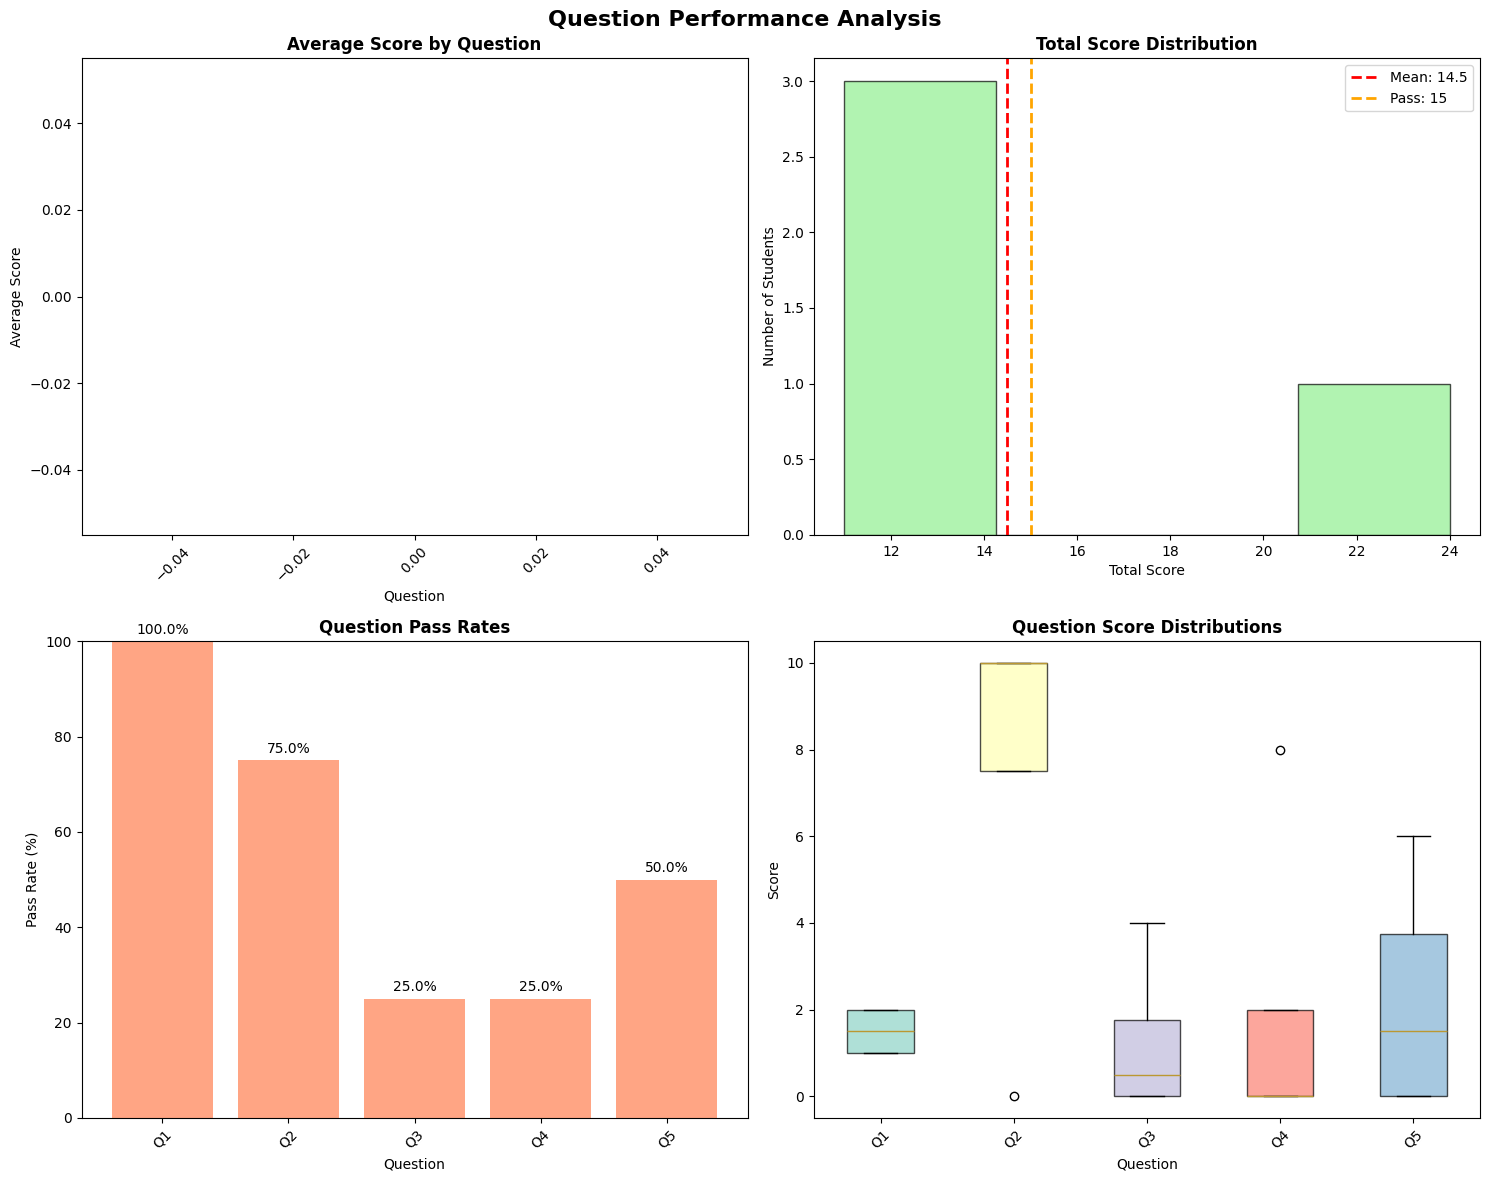

2026-01-09 07:59:24,785 - INFO - ✓ Generated question analysis charts: question_analysis_charts.png
2026-01-09 07:59:24,804 - INFO - ✓ Generated question metrics for 5 questions


📊 Saved QuestionMetrics sheet in: details_score_report.xlsx


,Question,Mean,Median,StdDev,Min,Max,NonNull,Pass Cutoff,Pass Rate (%)
0,Q1,1.50,1.5,0.577350,1.0,2.0,4,1.0,100.0
1,Q2,7.50,10.0,5.000000,0.0,10.0,4,5.0,75.0
2,Q3,1.25,0.5,1.892969,0.0,4.0,4,2.0,25.0
3,Q4,2.00,0.0,4.000000,0.0,8.0,4,4.0,25.0
4,Q5,2.25,1.5,2.872281,0.0,6.0,4,3.0,50.0


📊 Generating question-level metrics and visualizations...


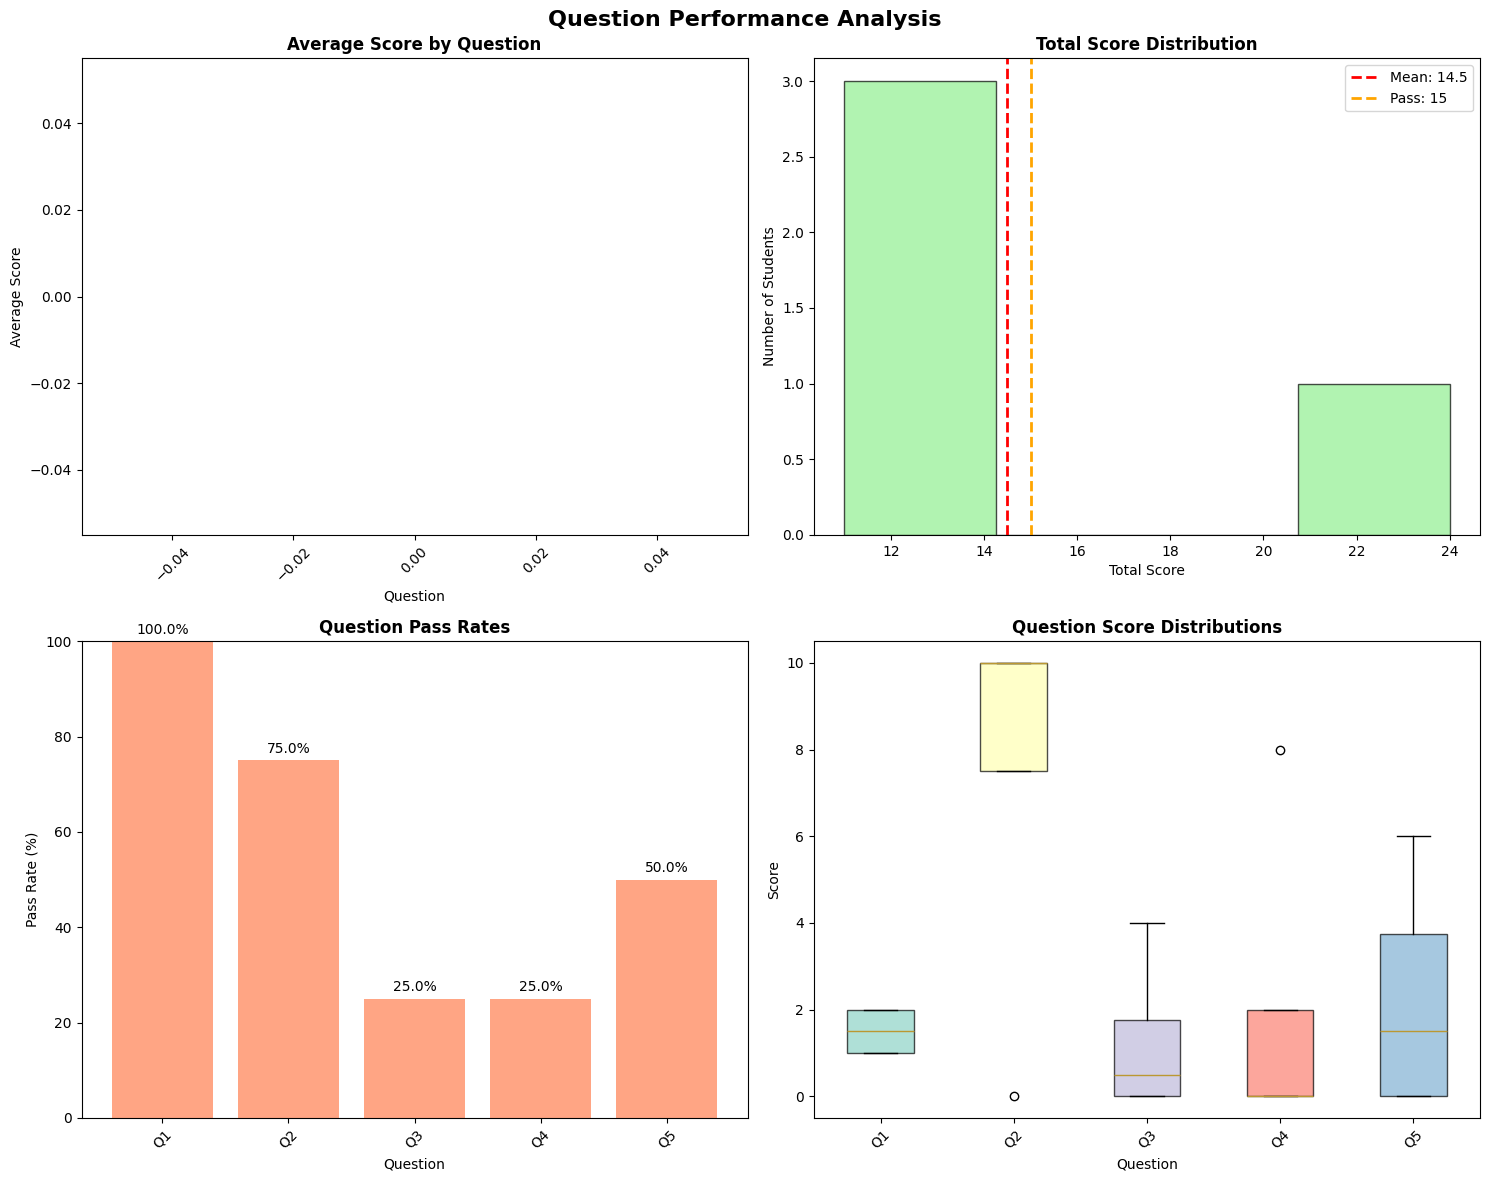

2026-01-09 07:59:28,992 - INFO - ✓ Generated question analysis charts: question_analysis_charts.png
2026-01-09 07:59:28,993 - INFO - ✓ Generated question metrics for 5 questions


📊 Saved QuestionMetrics sheet in: details_score_report.xlsx


,Question,Mean,Median,StdDev,Min,Max,NonNull,Pass Cutoff,Pass Rate (%)
0,Q1,1.50,1.5,0.577350,1.0,2.0,4,1.0,100.0
1,Q2,7.50,10.0,5.000000,0.0,10.0,4,5.0,75.0
2,Q3,1.25,0.5,1.892969,0.0,4.0,4,2.0,25.0
3,Q4,2.00,0.0,4.000000,0.0,8.0,4,4.0,25.0
4,Q5,2.25,1.5,2.872281,0.0,6.0,4,3.0,50.0


In [8]:
# Robust Question-Level Metrics and Visualizations
def generate_question_metrics():
    """Generate detailed question-level performance metrics and visualizations"""
    print("📊 Generating question-level metrics and visualizations...")
    
    try:
        # Question columns (excluding metadata)
        question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"] and c not in METADATA_QUESTIONS]
        
        if not question_cols:
            logger.warning("No question columns found for metrics")
            return pd.DataFrame()
        
        # Calculate question-level statistics
        question_stats = []
        passing_cutoff = globals().get("passingMark", 15)
        
        for q in question_cols:
            q_data = marksDf[q].apply(pd.to_numeric, errors='coerce').dropna()
            if len(q_data) == 0:
                continue
                
            # Assume 50% of max score as passing for individual questions
            q_max = q_data.max()
            q_pass_cutoff = q_max * 0.5 if q_max > 0 else 0
            q_pass_count = (q_data >= q_pass_cutoff).sum()
            q_pass_rate = (q_pass_count / len(q_data) * 100) if len(q_data) > 0 else 0
            
            question_stats.append({
                "Question": q,
                "Mean": round(q_data.mean(), 2),
                "Median": round(q_data.median(), 2),
                "StdDev": round(q_data.std(), 6),
                "Min": round(q_data.min(), 2),
                "Max": round(q_data.max(), 2),
                "NonNull": len(q_data),
                "Pass Cutoff": round(q_pass_cutoff, 2),
                "Pass Rate (%)": round(q_pass_rate, 1)
            })
        
        question_metrics_df = pd.DataFrame(question_stats)
        
        # Save question metrics to Excel
        with pd.ExcelWriter(
            details_report_path,
            mode="a" if os.path.exists(details_report_path) else "w",
            engine="openpyxl" if os.path.exists(details_report_path) else None,
            if_sheet_exists="replace" if os.path.exists(details_report_path) else None,
        ) as writer:
            question_metrics_df.to_excel(writer, sheet_name="QuestionMetrics", index=False)

        # Generate visualizations
        if len(question_cols) > 0:
            try:
                # Set up the plotting style
                plt.style.use('default')
                sns.set_palette("husl")
                
                # Create subplots for different visualizations
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))
                fig.suptitle('Question Performance Analysis', fontsize=16, fontweight='bold')
                
                # 1. Question means bar chart
                ax1 = axes[0, 0]
                question_means = marksDf[question_cols].mean(numeric_only=True)
                bars1 = ax1.bar(question_means.index, question_means.values, color='skyblue', alpha=0.7)
                ax1.set_title('Average Score by Question', fontweight='bold')
                ax1.set_xlabel('Question')
                ax1.set_ylabel('Average Score')
                ax1.tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar in bars1:
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                            f'{height:.1f}', ha='center', va='bottom')
                
                # 2. Score distribution histogram
                ax2 = axes[0, 1]
                ax2.hist(marksDf['Marks'], bins=min(10, len(marksDf)), color='lightgreen', alpha=0.7, edgecolor='black')
                ax2.axvline(marksDf['Marks'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {marksDf["Marks"].mean():.1f}')
                ax2.axvline(passing_cutoff, color='orange', linestyle='--', linewidth=2, label=f'Pass: {passing_cutoff}')
                ax2.set_title('Total Score Distribution', fontweight='bold')
                ax2.set_xlabel('Total Score')
                ax2.set_ylabel('Number of Students')
                ax2.legend()
                
                # 3. Question difficulty (pass rates)
                ax3 = axes[1, 0]
                if not question_metrics_df.empty:
                    bars3 = ax3.bar(question_metrics_df['Question'], question_metrics_df['Pass Rate (%)'], 
                                   color='coral', alpha=0.7)
                    ax3.set_title('Question Pass Rates', fontweight='bold')
                    ax3.set_xlabel('Question')
                    ax3.set_ylabel('Pass Rate (%)')
                    ax3.tick_params(axis='x', rotation=45)
                    ax3.set_ylim(0, 100)
                    
                    # Add value labels on bars
                    for bar in bars3:
                        height = bar.get_height()
                        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                                f'{height:.1f}%', ha='center', va='bottom')
                
                # 4. Question score ranges (box plot)
                ax4 = axes[1, 1]
                question_data = [marksDf[col].apply(pd.to_numeric, errors='coerce').dropna() for col in question_cols]
                bp = ax4.boxplot(question_data, tick_labels=question_cols, patch_artist=True)
                ax4.set_title('Question Score Distributions', fontweight='bold')
                ax4.set_xlabel('Question')
                ax4.set_ylabel('Score')
                ax4.tick_params(axis='x', rotation=45)
                
                # Color the box plots
                colors = plt.cm.Set3(range(len(bp['boxes'])))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                plt.tight_layout()
                
                # Save the plot
                # Create charts directory
                charts_dir = os.path.join(base_path_marked_scripts, "charts")
                os.makedirs(charts_dir, exist_ok=True)
                
                chart_path = os.path.join(charts_dir, "question_analysis_charts.png")
                plt.savefig(chart_path, dpi=300, bbox_inches='tight')
                plt.show()
                
                logger.info(f"✓ Generated question analysis charts: {os.path.basename(chart_path)}")
                
            except Exception as e:
                logger.warning(f"Failed to generate visualizations: {e}")
        
        logger.info(f"✓ Generated question metrics for {len(question_cols)} questions")
        print(f"📊 Saved QuestionMetrics sheet in: {os.path.basename(details_report_path)}")
        
        return question_metrics_df
        
    except Exception as e:
        logger.error(f"❌ Question metrics generation failed: {e}")
        return pd.DataFrame()

# Generate question metrics and visualizations
question_metrics_df = generate_question_metrics()
if not question_metrics_df.empty:
    display(question_metrics_df)

# Generate question metrics and visualizations
question_metrics_df = generate_question_metrics()
if not question_metrics_df.empty:
    display(question_metrics_df)

In [9]:
# Robust Question Analysis with AI
from agents.analytics_agent.agent import generate_question_insights_with_ai

async def generate_question_insights():
    """Generate AI-powered deep dive analysis for questions"""
    print("🤖 Generating Gemini-powered question insights...")

    try:
        # 1. Gather Data
        # Ensure question metrics are available
        metrics_df = None
        if 'question_metrics_df' in globals():
            metrics_df = globals()['question_metrics_df']
        else:
             try:
                 metrics_df = pd.read_excel(details_report_path, sheet_name="QuestionMetrics")
             except:
                 logger.warning("Question metrics not found. Skipping insights.")
                 return

        if metrics_df is None or metrics_df.empty:
            logger.warning("No question metrics data available.")
            return

        # Load marking scheme for context
        marking_scheme_file = paths["marking_scheme_file"]
        marking_scheme_data = {}
        if os.path.exists(marking_scheme_file):
            try:
                ms_df = pd.read_excel(marking_scheme_file, sheet_name="Marking Scheme")
                for _, row in ms_df.iterrows():
                    q_raw = str(row.get('question_number', ''))
                    q_label = q_raw if q_raw.upper().startswith('Q') else f"Q{q_raw}"
                    marking_scheme_data[q_label] = {
                        "text": row.get('question_text', ''),
                        "scheme": row.get('marking_scheme', ''),
                        "marks": row.get('marks', '')
                    }
            except Exception as e:
                logger.warning(f"Failed to load marking scheme: {e}")

        # Gather sample answers (Low vs High) for each question
        question_samples = {}
        question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"] and c not in METADATA_QUESTIONS]

        for q in question_cols:
            if q not in marksDf.columns: continue

            def get_ans(sid):
                if answers_sheet.empty: return ""
                row = answers_sheet[answers_sheet['ID'].astype(str) == str(sid)]
                if row.empty: return ""
                return str(row.iloc[0].get(q, ""))

            q_marks = marksDf[['ID', q]].copy()
            q_marks['Answer'] = q_marks['ID'].apply(get_ans)
            q_marks = q_marks.sort_values(by=q, ascending=False)

            top_students = q_marks.head(2).to_dict(orient='records')
            bottom_students = q_marks.tail(2).to_dict(orient='records')

            question_samples[q] = {
                "top_answers": [
                    {"mark": s[q], "answer": s['Answer']} for s in top_students if pd.notna(s['Answer']) and s['Answer'] != ""
                ],
                "bottom_answers": [
                    {"mark": s[q], "answer": s['Answer']} for s in bottom_students if pd.notna(s['Answer']) and s['Answer'] != ""
                ]
            }

        # 2. Iterate and Generate Insights Per Question
        all_insights = []
        
        # Progress bar
        progress = IntProgress(min=0, max=len(metrics_df), description="Question Insights")
        display(progress)

        for index, row in metrics_df.iterrows():
            q = row['Question']
            stats = row.to_dict()
            ms = marking_scheme_data.get(q, {})
            samples = question_samples.get(q, {})

            payload = {
                "question": q,
                "stats": stats,
                "marking_scheme": ms,
                "samples": samples
            }
            
            logger.info(f"Generating insight for {q}...")
            
            # Call AI
            result = await generate_question_insights_with_ai(payload)

            # Handle Result
            report_text = ""
            infograph_path = ""
            
            if hasattr(result, 'report_text'):
                report_text = result.report_text
                infograph_path = result.infograph_image_path
            elif isinstance(result, dict):
                 report_text = result.get('report_text', '')
                 infograph_path = result.get('infograph_image_path', '')
            else:
                 report_text = str(result)
            
            all_insights.append({
                "Question": q,
                "Insight": report_text,
                "Infographic": infograph_path
            })
            progress.value += 1

        # 3. Output and Save
        print(f"\n✅ Generated insights for {len(all_insights)} questions.")
        
        # Display first one as example
        if all_insights:
            print(f"\n🔍 Example Insight ({all_insights[0]['Question']}):")
            print(all_insights[0]['Insight'][:500] + "...")
            if all_insights[0]['Infographic']:
                print(f"📊 Infographic: {all_insights[0]['Infographic']}")

        # Save to Excel
        insights_df = pd.DataFrame(all_insights)
        
        with pd.ExcelWriter(
            details_report_path,
            mode="a",
            engine="openpyxl",
            if_sheet_exists="replace",
        ) as writer:
            insights_df.to_excel(writer, sheet_name="QuestionInsights", index=False)
        
        logger.info(f"✓ Saved per-question insights to {details_report_path}")
        
        # Expose the dataframe globally for later steps if needed
        globals()['question_insights_df'] = insights_df

    except Exception as e:
        logger.error(f"❌ Question insights generation failed: {e}")
        print(f"❌ Error: {e}")

# Run
await generate_question_insights()

🤖 Generating Gemini-powered question insights...


IntProgress(value=0, description='Question Insights', max=5)

2026-01-09 07:59:29,269 - INFO - Generating insight for Q1...
2026-01-09 07:59:29,273 - INFO - AI execution attempt 1/3 for question_analysis_generator
2026-01-09 07:59:29,604 - INFO - Sending out request, model: gemini-3-flash-preview, backend: GoogleLLMVariant.VERTEX_AI, stream: False
2026-01-09 07:59:29,609 - INFO - AFC is enabled with max remote calls: 10.
2026-01-09 07:59:40,173 - INFO - HTTP Request: POST https://aiplatform.googleapis.com/v1beta1/publishers/google/models/gemini-3-flash-preview:generateContent "HTTP/1.1 200 OK"
2026-01-09 07:59:40,180 - INFO - Response received from the model.
2026-01-09 07:59:40,564 - INFO - Sending out request, model: gemini-3-flash-preview, backend: GoogleLLMVariant.VERTEX_AI, stream: False
2026-01-09 07:59:45,548 - INFO - HTTP Request: POST https://aiplatform.googleapis.com/v1beta1/publishers/google/models/gemini-3-flash-preview:generateContent "HTTP/1.1 200 OK"
2026-01-09 07:59:45,558 - INFO - Response received from the model.
2026-01-09 07:5


✅ Generated insights for 5 questions.

🔍 Example Insight (Q1):
**Analysis of Q1: The Role of VTC and VPET**

**The Hurdle**
Low-scoring students struggled with technical precision and prompt adherence. Evidence from "bottom_answers" shows students either provided vague thematic phrases like "Hong Kong skilled labor force" or attempted the acronym but failed due to significant spelling and conceptual errors (e.g., "Vacational" and "Eduate Trarning"). These students missed the foundational marks for the correct terminology and entirely ignored the second half...
📊 Infographic: /home/user/gemini-handwriting-grader/cache/class_overview_report/infograph_question_9b7867ec3f51410db85ac5a80b503b24.png


In [10]:
def generate_word_report():
    """Generate comprehensive Word document report with charts and analytics"""
    print("📄 Generating comprehensive Word document report...")
    
    try:
        from docx import Document
        from docx.enum.text import WD_ALIGN_PARAGRAPH
        from docx.shared import Pt, Inches
        import re
        import os
        
        # Ensure required data is available
        if 'class_overview_df' not in globals() or class_overview_df.empty:
            logger.warning("Class overview data not available, generating basic report")
            return None
        
        # Create charts directory
        charts_dir = os.path.join(base_path_marked_scripts, "charts")
        os.makedirs(charts_dir, exist_ok=True)
        
        # Initialize Word document
        word_path = os.path.join(base_path_marked_scripts, "class_overview_report.docx")
        doc = Document()
        
        # Base styles
        doc.styles["Normal"].font.size = Pt(11)
        
        # Document title
        title_text = "Class Performance Overview"
        if "prefix" in globals() and prefix:
            title_text = f"{prefix} - {title_text}"
        doc.add_heading(title_text, level=1)
        
        # Key stats summary
        total_students = len(marksDf)
        avg_score = marksDf['Marks'].mean()
        median_score = marksDf['Marks'].median()
        pass_count = len(marksDf[marksDf['Marks'] > passingMark])
        pass_rate = (pass_count / total_students * 100) if total_students > 0 else 0
        
        summary_line = (
            f"Students: {total_students} | Mean: {avg_score:.2f} | Median: {median_score:.2f} | "
            f"Pass rate: {pass_rate:.1f}% (cutoff {passingMark})"
        )
        doc.add_paragraph(summary_line)
        
        def add_markdown_line(md_line, bullet=False, heading_level=None):
            """Render a single markdown line into the docx with bold/italic support."""
            if heading_level:
                p = doc.add_heading(level=heading_level)
            elif bullet:
                p = doc.add_paragraph(style="List Bullet")
            else:
                p = doc.add_paragraph()

            tokens = re.split(r"(\*\*[^*]+\*\*|__[^_]+__|\*[^*]+\*|_[^_]+_)", md_line)
            for tok in tokens:
                if not tok:
                    continue
                bold = tok.startswith("**") or tok.startswith("__")
                italic = tok.startswith("*") or tok.startswith("_")
                clean = tok.strip("*_ ")
                run = p.add_run(clean)
                if bold:
                    run.bold = True
                if italic:
                    run.italic = True
            return p
        
        # Add Gemini narrative if available
        if 'class_overview_df' in globals():
            gemini_overview = class_overview_df[class_overview_df['Metric'] == 'Gemini Class Overview']
            if not gemini_overview.empty:
                class_overview_report = gemini_overview.iloc[0]['Value']
                if class_overview_report and str(class_overview_report) != 'nan':
                    doc.add_heading("AI-Generated Class Analysis", level=2)
                    for raw_line in str(class_overview_report).splitlines():
                        line = raw_line.rstrip()
                        if not line:
                            continue
                        heading_match = re.match(r"^(#{1,3})\s+(.*)$", line)
                        if heading_match:
                            level = len(heading_match.group(1))
                            add_markdown_line(heading_match.group(2), heading_level=level)
                            continue
                        if re.match(r"^[-*+]\s+", line):
                            add_markdown_line(line[2:].strip(), bullet=True)
                            continue
                        num_match = re.match(r"^\d+\.\s+(.*)$", line)
                        if num_match:
                            p = add_markdown_line(num_match.group(1))
                            p.style = "List Number"
                            continue
                        p = add_markdown_line(line)
                        p.alignment = WD_ALIGN_PARAGRAPH.LEFT
        
        # Add Infographic if available
        if 'class_overview_infograph_path' in globals() and class_overview_infograph_path and os.path.exists(class_overview_infograph_path):
            try:
                doc.add_page_break()
                doc.add_heading("Class Performance Infographic", level=2)
                doc.add_paragraph("AI-generated visual summary of class performance:")
                doc.add_picture(class_overview_infograph_path, width=Inches(6))
                logger.info(f"✓ Added infographic to Word report: {os.path.basename(class_overview_infograph_path)}")
            except Exception as e:
                logger.warning(f"Failed to add infographic to Word report: {e}")
        
        # Add AI Question Insights
        if 'question_insights_df' in globals() and not question_insights_df.empty:
            doc.add_page_break()
            doc.add_heading("Deep Dive Question Insights", level=2)
            doc.add_paragraph("AI-powered analysis of key questions, highlighting common misconceptions and teaching opportunities.")

            for _, row in question_insights_df.iterrows():
                q = row.get('Question', 'Unknown Question')
                insight = row.get('Insight', '')
                infograph = row.get('Infographic', '')
                
                # Add visual separator or heading
                doc.add_heading(f"Analysis: {q}", level=3)
                
                # Render markdown insight text
                if insight and str(insight) != 'nan':
                    for raw_line in str(insight).splitlines():
                        line = raw_line.rstrip()
                        if not line:
                            continue
                        
                        # Handle headings/bold lines
                        heading_match = re.match(r"^(#{1,3})\s+(.*)$", line)
                        if heading_match:
                            level = min(3, len(heading_match.group(1)) + 2) # Map # to level 3+, maxing reasonably
                            add_markdown_line(heading_match.group(2), heading_level=level)
                            continue
                            
                        # Handle bullets
                        if re.match(r"^[-*+]\s+", line):
                            add_markdown_line(line.lstrip("-*+ ").strip(), bullet=True)
                            continue
                            
                        # Handle numbered lists
                        num_match = re.match(r"^\d+\.\s+(.*)$", line)
                        if num_match:
                            p = add_markdown_line(num_match.group(1))
                            p.style = "List Number"
                            continue
                            
                        # Standard paragraph
                        p = add_markdown_line(line)
                
                # Add infographic image
                if infograph and str(infograph) != 'nan' and os.path.exists(infograph):
                    try:
                        doc.add_paragraph() # Spacer
                        doc.add_picture(infograph, width=Inches(6))
                        logger.info(f"✓ Added infographic to Word report for {q}")
                    except Exception as e:
                        logger.warning(f"Failed to add infographic for {q}: {e}")
                
                doc.add_paragraph() # Spacer after question section

        
        # Add strengths and focus areas
        if 'class_overview_df' in globals():
            strengths_row = class_overview_df[class_overview_df['Metric'] == 'Top Strength Questions']
            focus_row = class_overview_df[class_overview_df['Metric'] == 'Top Focus Questions']
            
            if not strengths_row.empty and str(strengths_row.iloc[0]['Value']) != '':
                doc.add_heading("Top Strength Questions", level=2)
                strengths_text = str(strengths_row.iloc[0]['Value'])
                for item in strengths_text.split(', '):
                    if item.strip():
                        doc.add_paragraph(item.strip(), style="List Bullet")
            
            if not focus_row.empty and str(focus_row.iloc[0]['Value']) != '':
                doc.add_heading("Areas Needing Focus", level=2)
                focus_text = str(focus_row.iloc[0]['Value'])
                for item in focus_text.split(', '):
                    if item.strip():
                        doc.add_paragraph(item.strip(), style="List Bullet")
        
        # Generate and add class-level charts
        try:
            overall_hist = os.path.join(charts_dir, "overall_hist.png")
            pass_bar = os.path.join(charts_dir, "pass_bar.png")
            
            # Score distribution histogram
            plt.figure(figsize=(8, 4))
            plt.hist(pd.to_numeric(marksDf["Marks"], errors="coerce").dropna(), bins=20, color="#4a90e2", alpha=0.7, edgecolor='black')
            plt.xlabel("Total Score")
            plt.ylabel("Number of Students")
            plt.title("Score Distribution (Class)")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(overall_hist, dpi=180, bbox_inches='tight')
            plt.close()
            
            # Pass/Fail bar chart
            plt.figure(figsize=(6, 4))
            fail_count = total_students - pass_count
            plt.bar(["Pass", "Fail"], [pass_count, fail_count], color=["#4caf50", "#e74c3c"], alpha=0.7)
            plt.ylabel("Number of Students")
            plt.title("Pass / Fail Distribution")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(pass_bar, dpi=180, bbox_inches='tight')
            plt.close()
            
            # Add charts to document
            doc.add_page_break()
            doc.add_heading("Class Performance Charts", level=2)
            doc.add_paragraph("Score histogram shows the distribution of total scores across all students.")
            doc.add_picture(overall_hist, width=Inches(6))
            doc.add_paragraph("Pass/Fail distribution shows how many students met the passing criteria.")
            doc.add_picture(pass_bar, width=Inches(4))
            
        except Exception as e:
            logger.warning(f"Failed to generate class charts: {e}")
        
        # Add metrics table
        if 'class_overview_df' in globals() and not class_overview_df.empty:
            table_df = class_overview_df.copy()
            # Exclude the Gemini overview from the metrics table
            table_df = table_df[table_df["Metric"] != "Gemini Class Overview"]
            
            if not table_df.empty:
                doc.add_page_break()
                doc.add_heading("Performance Metrics", level=2)
                table = doc.add_table(rows=1, cols=2, style="Light Grid")
                hdr_cells = table.rows[0].cells
                hdr_cells[0].text = "Metric"
                hdr_cells[1].text = "Value"
                
                for _, row in table_df.iterrows():
                    cells = table.add_row().cells
                    cells[0].text = str(row["Metric"])
                    cells[1].text = str(row["Value"])
        
        # Add per-question metrics if available
        if 'question_metrics_df' in globals() and not question_metrics_df.empty:
            doc.add_page_break()
            doc.add_heading("Per-Question Analysis", level=2)
            
            # Create question metrics table
            pq_table = doc.add_table(rows=1, cols=6, style="Light Grid")
            hdr = pq_table.rows[0].cells
            hdr[0].text = "Question"
            hdr[1].text = "Mean"
            hdr[2].text = "Median"
            hdr[3].text = "StdDev"
            hdr[4].text = "Min / Max"
            hdr[5].text = "Pass Rate (%)"
            
            for _, r in question_metrics_df.iterrows():
                cells = pq_table.add_row().cells
                cells[0].text = str(r.get("Question", ""))
                cells[1].text = f"{r['Mean']:.2f}" if pd.notna(r.get("Mean")) else ""
                cells[2].text = f"{r['Median']:.2f}" if pd.notna(r.get("Median")) else ""
                cells[3].text = f"{r['StdDev']:.2f}" if pd.notna(r.get("StdDev")) else ""
                min_val = f"{r['Min']:.2f}" if pd.notna(r.get("Min")) else ""
                max_val = f"{r['Max']:.2f}" if pd.notna(r.get("Max")) else ""
                cells[4].text = f"{min_val} / {max_val}" if (min_val or max_val) else ""
                cells[5].text = f"{r['Pass Rate (%)']:.1f}" if pd.notna(r.get("Pass Rate (%)")) else ""
            
            # Generate and add question-level charts
            try:
                mean_chart = os.path.join(charts_dir, "question_mean.png")
                box_chart = os.path.join(charts_dir, "question_box.png")
                pass_rate_chart = os.path.join(charts_dir, "question_pass_rate.png")
                
                # Question means with error bars
                plt.figure(figsize=(10, 5))
                plt.bar(question_metrics_df["Question"], question_metrics_df["Mean"], 
                       yerr=question_metrics_df["StdDev"], capsize=4, alpha=0.7, color='skyblue')
                plt.ylabel("Mean Score")
                plt.title("Mean Score per Question")
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig(mean_chart, dpi=180, bbox_inches='tight')
                plt.close()
                
                # Box plots for score distributions
                question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"] and c not in METADATA_QUESTIONS]
                if question_cols:
                    plt.figure(figsize=(10, 5))
                    box_data = [pd.to_numeric(marksDf[q], errors="coerce").dropna() for q in question_cols]
                    plt.boxplot(box_data, tick_labels=question_cols)
                    plt.ylabel("Score")
                    plt.title("Score Distribution per Question")
                    plt.xticks(rotation=45)
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.savefig(box_chart, dpi=180, bbox_inches='tight')
                    plt.close()
                
                # Pass rate chart
                plt.figure(figsize=(10, 5))
                plt.bar(question_metrics_df["Question"], question_metrics_df["Pass Rate (%)"], 
                       color="#7b7ce6", alpha=0.7)
                plt.ylabel("Pass Rate (%)")
                plt.title("Pass Rate per Question")
                plt.xticks(rotation=45)
                plt.ylim(0, 100)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig(pass_rate_chart, dpi=180, bbox_inches='tight')
                plt.close()
                
                # Add charts to document
                doc.add_paragraph("Mean score bars show average performance per question, with error bars indicating variability.")
                doc.add_picture(mean_chart, width=Inches(6))
                
                if question_cols:
                    doc.add_paragraph("Box plots show the distribution of scores for each question (median, quartiles, and outliers).")
                    doc.add_picture(box_chart, width=Inches(6))
                
                doc.add_paragraph("Pass rate bars show the percentage of students who achieved at least half marks for each question.")
                doc.add_picture(pass_rate_chart, width=Inches(6))
                
            except Exception as e:
                logger.warning(f"Failed to generate question charts: {e}")

        
        # Add footer with generation info
        footer = doc.add_paragraph()
        footer_run = footer.add_run(f"Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | Robust Step 6 Processing")
        footer_run.font.size = Pt(9)
        footer.alignment = WD_ALIGN_PARAGRAPH.CENTER
        
        # Save the document
        doc.save(word_path)
        logger.info(f"✓ Generated Word report: {os.path.basename(word_path)}")
        print(f"📄 Saved Word report: {word_path}")
        
        return word_path
        
    except Exception as e:
        logger.error(f"❌ Word report generation failed: {e}")
        return None

# Generate Word document report
word_report_path = generate_word_report()
if word_report_path:
    print(f"✅ Word document report generated successfully!")
    print(f"📁 Location: {word_report_path}")
else:
    print("⚠️ Word document generation was skipped due to missing data or errors")

2026-01-09 08:03:57,863 - INFO - ✓ Added infographic to Word report: infograph_8f49732f58804014a948afd29116a854.png
2026-01-09 08:03:57,884 - INFO - ✓ Added infographic to Word report for Q1
2026-01-09 08:03:57,912 - INFO - ✓ Added infographic to Word report for Q2


📄 Generating comprehensive Word document report...


2026-01-09 08:03:57,943 - INFO - ✓ Added infographic to Word report for Q3
2026-01-09 08:03:57,984 - INFO - ✓ Added infographic to Word report for Q4
2026-01-09 08:03:58,023 - INFO - ✓ Added infographic to Word report for Q5
2026-01-09 08:04:02,660 - INFO - ✓ Generated Word report: class_overview_report.docx


📄 Saved Word report: ../marking_form/VTC Test/marked/scripts/class_overview_report.docx
✅ Word document report generated successfully!
📁 Location: ../marking_form/VTC Test/marked/scripts/class_overview_report.docx


In [11]:
# Robust PowerPoint Report Generation
def generate_pptx_report():
    'Generate PowerPoint presentation with infographics and speaker notes'
    print("🖥️ Generating PowerPoint presentation...")
    
    try:
        from pptx import Presentation
        from pptx.util import Inches, Pt
        from pptx.enum.text import PP_ALIGN
        import os
        
        pptx_path = os.path.join(base_path_marked_scripts, "class_overview_presentation.pptx")
        prs = Presentation()
        
        # Set 16:9 Aspect Ratio (13.333" x 7.5")
        prs.slide_width = Inches(13.333)
        prs.slide_height = Inches(7.5)
        
        # --- Title Slide (Slide 1) ---
        slide_layout = prs.slide_layouts[0] # Title Slide
        slide = prs.slides.add_slide(slide_layout)
        title = slide.shapes.title
        subtitle = slide.placeholders[1]
        
        title_text = "Class Performance Overview"
        if "prefix" in globals() and prefix:
            title_text = f"{prefix} - {title_text}"
        title.text = title_text
        subtitle.text = f"Generated on {datetime.now().strftime('%Y-%m-%d')}"
        
        # FIX: Explicitly position Title and Subtitle to prevent overlap/top-bunching
        # 1. Title Position
        title.left = Inches(0)
        title.width = prs.slide_width
        title.top = Inches(2.5) # Approx 1/3 down
        title.height = Inches(1.5)
        for paragraph in title.text_frame.paragraphs:
            paragraph.alignment = PP_ALIGN.CENTER
            
        # 2. Subtitle Position
        subtitle.left = Inches(0)
        subtitle.width = prs.slide_width
        subtitle.top = Inches(4.2) # Below title
        subtitle.height = Inches(1.0)
        for paragraph in subtitle.text_frame.paragraphs:
            paragraph.alignment = PP_ALIGN.CENTER
        
        # --- Helper for Content Slides ---
        def add_infographic_slide(title_text, image_path, notes_text):
            if not image_path or not os.path.exists(image_path):
                logger.warning(f"Image not found for slide '{title_text}': {image_path}")
                return
                
            slide_layout = prs.slide_layouts[5] # Title Only
            slide = prs.slides.add_slide(slide_layout)
            
            # Add title and center it
            if slide.shapes.title:
                slide.shapes.title.text = title_text
                
                # Fix title position for content slides
                slide.shapes.title.left = Inches(0)
                slide.shapes.title.width = prs.slide_width
                slide.shapes.title.top = Inches(0.5) 
                
                # Ensure centered alignment
                if slide.shapes.title.text_frame:
                    for paragraph in slide.shapes.title.text_frame.paragraphs:
                        paragraph.alignment = PP_ALIGN.CENTER
            
            # --- Improved Image Positioning ---
            
            # Define content area boundaries
            content_top_boundary = Inches(1.5)
            content_bottom_boundary = prs.slide_height - Inches(0.5)
            
            available_height = content_bottom_boundary - content_top_boundary
            available_width = prs.slide_width - Inches(1.0) # 0.5" margin on each side
            
            # Get image aspect ratio using PIL
            from PIL import Image
            try:
                with Image.open(image_path) as img:
                    img_w, img_h = img.size
                    aspect_ratio = img_w / img_h
            except Exception as e:
                logger.warning(f"Failed to read image dimensions for {image_path}: {e}")
                aspect_ratio = 1.77 # Default 16:9 fallback
            
            # Calculate max dimensions in EMU
            max_w_emu = available_width
            max_h_emu = available_height
            
            # Calculate target dimensions
            target_width = max_w_emu
            target_height = int(max_w_emu / aspect_ratio)
            
            if target_height > max_h_emu:
                target_height = max_h_emu
                target_width = int(max_h_emu * aspect_ratio)
            
            # Center horizontally
            left_pos = int((prs.slide_width - target_width) / 2)
            
            # Center vertically in the available space below title
            top_pos = int(content_top_boundary + (available_height - target_height) / 2)
            
            slide.shapes.add_picture(image_path, left_pos, top_pos, width=target_width, height=target_height)
            
            # Add notes
            if notes_text:
                notes_slide = slide.notes_slide
                text_frame = notes_slide.notes_text_frame
                text_frame.text = str(notes_text)

        # 1. Class Overview Slide
        overview_text = ""
        if 'class_overview_df' in globals() and not class_overview_df.empty:
            gemini_rows = class_overview_df[class_overview_df['Metric'] == 'Gemini Class Overview']
            if not gemini_rows.empty:
                overview_text = str(gemini_rows.iloc[0]['Value'])
        
        if 'class_overview_infograph_path' in globals() and class_overview_infograph_path:
            add_infographic_slide("Class Overview", class_overview_infograph_path, overview_text)
            logger.info("✓ Added Class Overview slide")
            
        # 2. Question Insights Slides
        if 'question_insights_df' in globals() and not question_insights_df.empty:
            for _, row in question_insights_df.iterrows():
                q = row.get('Question', 'Unknown Question')
                insight = row.get('Insight', '')
                infograph = row.get('Infographic', '')
                
                add_infographic_slide(f"Analysis: {q}", infograph, insight)
                logger.info(f"✓ Added slide for {q}")
        
        # Save
        prs.save(pptx_path)
        logger.info(f"✓ Saved PowerPoint report: {os.path.basename(pptx_path)}")
        print(f"🖥️ Saved PowerPoint report: {pptx_path}")
        return pptx_path
        
    except Exception as e:
        logger.error(f"❌ PowerPoint generation failed: {e}")
        print(f"⚠️ PowerPoint generation failed: {e}")
        return None

# Generate PowerPoint report
pptx_report_path = generate_pptx_report()
if pptx_report_path:
    print(f"✅ PowerPoint report generated successfully!")


🖥️ Generating PowerPoint presentation...


2026-01-09 08:04:03,638 - INFO - ✓ Added Class Overview slide
2026-01-09 08:04:03,681 - INFO - ✓ Added slide for Q1
2026-01-09 08:04:03,729 - INFO - ✓ Added slide for Q2
2026-01-09 08:04:03,780 - INFO - ✓ Added slide for Q3
2026-01-09 08:04:03,827 - INFO - ✓ Added slide for Q4
2026-01-09 08:04:03,873 - INFO - ✓ Added slide for Q5
2026-01-09 08:04:04,664 - INFO - ✓ Saved PowerPoint report: class_overview_presentation.pptx


🖥️ Saved PowerPoint report: ../marking_form/VTC Test/marked/scripts/class_overview_presentation.pptx
✅ PowerPoint report generated successfully!


In [12]:
# Robust backup and cleanup with validation
def backup_and_cleanup():
    """Robust backup with comprehensive validation and error handling"""
    print("🧹 Performing backup and cleanup...")
    
    try:
        # Remove version history files with progress tracking
        version_files_removed = 0
        for path, _, files in os.walk(base_path_questions):
            for file in files:
                if file.startswith("control-") or file.startswith("mark-"):
                    try:
                        os.remove(os.path.join(path, file))
                        version_files_removed += 1
                    except Exception as e:
                        logger.warning(f"Failed to remove {file}: {e}")
        logger.info(f"✓ Removed {version_files_removed} version history files")
        
        # Create backup archive with validation
        backup_path = shutil.make_archive(base_path, "zip", base_path)
        if os.path.exists(backup_path):
            backup_size = os.path.getsize(backup_path)
            logger.info(f"✓ Created backup archive: {backup_path}")
            logger.info(f"  Archive size: {backup_size:,} bytes ({backup_size/1024/1024:.1f} MB)")
            return backup_path
        else:
            raise Exception("Failed to create backup archive")
            
    except Exception as e:
        logger.error(f"❌ Backup and cleanup failed: {e}")
        raise

# Perform backup and cleanup
backup_path = backup_and_cleanup()


2026-01-09 08:04:04,741 - INFO - ✓ Removed 0 version history files


🧹 Performing backup and cleanup...


2026-01-09 08:04:08,121 - INFO - ✓ Created backup archive: /home/user/gemini-handwriting-grader/marking_form/VTC Test.zip
2026-01-09 08:04:08,125 - INFO -   Archive size: 19,289,203 bytes (18.4 MB)
2026-01-09 08:04:08,125 - INFO -   Archive size: 19,289,203 bytes (18.4 MB)


In [13]:
# Robust final summary and next steps
def generate_final_summary():
    'Generate comprehensive final summary with actionable next steps'
    
    print("" + "="*70)
    print("🎉 STEP 6.2: AI ANALYSIS COMPLETE")
    print("="*70)
    
    # Overall statistics
    if 'marksDf' in globals():
        total_students = len(marksDf)
        avg_score = marksDf['Marks'].mean()
        # passingMark might be in globals, otherwise default 15
        pm = globals().get('passingMark', 15)
        passing_students = len(marksDf[marksDf['Marks'] > pm])
        pass_rate = (passing_students / total_students * 100) if total_students > 0 else 0
        
        print(f"📊 Processing Results:")
        print(f"   Total students processed: {total_students}")
        print(f"   Average score: {avg_score:.2f}")
        print(f"   Passing students: {passing_students} ({pass_rate:.1f}%)")
    
    print(f"📁 Generated Files (AI & Advanced):")
    if 'details_report_path' in globals():
        print(f"   ✅ Enhanced Excel report: {os.path.basename(details_report_path)}")
    if 'word_report_path' in globals() and word_report_path:
        print(f"   ✅ Word report: {os.path.basename(word_report_path)}")
    if 'pptx_report_path' in globals() and pptx_report_path:
        print(f"   ✅ PowerPoint report: {os.path.basename(pptx_report_path)}")
        
    print(f"🤖 AI Features Generated:")
    if 'performance_df' in globals() and not performance_df.empty:
        print(f"   ✅ Individual performance reports: {len(performance_df)}")
    if 'class_overview_df' in globals() and not class_overview_df.empty:
        print(f"   ✅ Class-level analytics")
    if 'question_insights_df' in globals() and not question_insights_df.empty:
        print(f"   ✅ Deep-dive question insights")

    print(f"🎯 Next Steps:")
    print(f"   1. 📧 Proceed to Step 7: Email Score Distribution")
    print(f"   2. 📊 Review 'class_overview_report.docx' and 'class_overview_presentation.pptx'")
    
    print("" + "="*70)
    print(f"✅ Step 6.2 completed successfully at {datetime.now().strftime('%H:%M:%S')}")
    print("="*70)

# Generate final comprehensive summary
generate_final_summary()


🎉 STEP 6.2: AI ANALYSIS COMPLETE
📊 Processing Results:
   Total students processed: 4
   Average score: 14.50
   Passing students: 1 (25.0%)
📁 Generated Files (AI & Advanced):
   ✅ Enhanced Excel report: details_score_report.xlsx
   ✅ Word report: class_overview_report.docx
   ✅ PowerPoint report: class_overview_presentation.pptx
🤖 AI Features Generated:
   ✅ Individual performance reports: 4
   ✅ Class-level analytics
   ✅ Deep-dive question insights
🎯 Next Steps:
   1. 📧 Proceed to Step 7: Email Score Distribution
   2. 📊 Review 'class_overview_report.docx' and 'class_overview_presentation.pptx'
✅ Step 6.2 completed successfully at 08:04:08
